In [231]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import warnings
from scipy.special import expit as sigmoid
from matplotlib.backends.backend_pdf import PdfPages


plt.ioff()

In [277]:
def H_inf(type, v, v_th):
    '''
    if type = 'zero', we will return 0 for any value of v, v_th
    if type = 'step', we will return 1 when v >= v_th, otherwise, we return zero
    if type = 'smooth step', we will return a logistic function centered at zero

    type: string, will be one of 'zero', 'step', 'smooth step'
    v: float, voltage
    v_th: float, threshold voltage
    '''
    if type == 'zero':
        return 0
    elif type == 'step':
        if v - v_th >= 0:
            return 1
        else:
            return 0
    elif type == 'smooth step':
        k = 100
        return sigmoid(k*(v - v_th/1.0))
    else:
        raise ValueError('First argument of H_inf must be one of "zero", "step", "smooth step".')
print('-----------------------------------------------------------------')
print('Test cases for H_inf function:')
print(H_inf('zero', 0, 1))
print(H_inf('step', 1, 0))
print(H_inf('step', 0, 35))
print(H_inf('smooth step', 32.5, 35))
print(H_inf('smooth step', 0, 35))
print('-----------------------------------------------------------------')
# print(H_inf('else', 132, 22)) # a ValueError is indeed raised

-----------------------------------------------------------------
Test cases for H_inf function:
0
1
0
2.6691902155412764e-109
0.0
-----------------------------------------------------------------


In [352]:
def two_neurons(neuron_para_dict, T, h, IC, method, conductance, H_inf_type):
    '''
    neuron_para_dict: it will be of the form
        'C': float,
        'k': float,
        'vr': float,
        'vt': float,
        'a': float,
        'b': float,
        'c': float,
        'd': float,
        'vpeak': float
    IC: it must be a numpy array of three numpy array, where each array has size two
    IC = [
    [IC for v1, IC for v2],
    [IC for u1, IC for u2],
    [IC for s1, IC for s2]
    ]
    method: will be one of 'RK'  or 'Euler'
    conductance: will be one of 'closed channels' or 'open and closed channels'
    H_inf_type: will be a function zeros, or a step function, or a smooth approximation of step function
    '''
    # Check whether method and conductance is in accordance with their description,
    # otherwise, raise an error
    method_allowable = ['RK', 'Euler']
    conductance_allowable = ['closed channels', 'open and closed channels']
    if method in method_allowable:
        pass
    else:
        raise ValueError('method argument must be one of "RK", "Euler".')

    if conductance in conductance_allowable:
        pass
    else:
        raise ValueError('conductance argument must be one of "closed channels", "open and closed channels".')
    
    # Extract the parameters from the neuron_para_dict
    C = neuron_para_dict['C']
    k = neuron_para_dict['k']
    vr = neuron_para_dict['vr']
    vt = neuron_para_dict['vt']
    a = neuron_para_dict['a']
    b = neuron_para_dict['b']
    c = neuron_para_dict['c']
    d = neuron_para_dict['d']
    vpeak = neuron_para_dict['vpeak']

    # Define the number of the datapoints
    datapoints = int(T // h)
    
    # Define the time space using equally spaced points
    time = np.linspace(0, int(T * h), datapoints)
    
    # Pre-allocate memeory for v, u, s
    # s is the fraction of open channels
    v = np.zeros([2, datapoints], dtype=np.float64)
    u = np.zeros([2, datapoints], dtype=np.float64)
    s = np.zeros([2, datapoints], dtype=np.float64)
    
    # Neuron 1
    v1 = v[0]
    u1 = u[0]
    s1 = s[0]
    
    # Neuron 2
    v2 = v[1]
    u2 = u[1]
    s2 = s[1]

    # Inserting IC for each variable
    v1[0] = IC[0][0]
    v2[0] = IC[0][1]
    u1[0] = IC[1][0]
    u2[0] = IC[1][1]
    s1[0] = IC[2][0]
    s2[0] = IC[2][1]

    # Defining constants
    # excitatory: v_syn = 0 mV for AMPA recpetor
    # inhibitory: v_syn \in [-81, -60] mV for GABA receptor
    # alpha: rate at which synapses turns on 
    # beat: rate at which synapses turns off
    g_syn = 0.1 * 10**-1
    v_syn = 0
    alpha = 0.4
    beta = 0.6

    # set the applied current and the heavside step function
    I_b = ((vt - vr)*k + b)**2/(4*k)
    I_app = np.zeros(datapoints)
    I_app[int(0.01 * datapoints):] = I_b * 1.02
    
    # The following are peak time, and the indices at which peak occurs
    peak_time_n1 = np.array([], dtype = np.float64)
    peak_time_n2 = np.array([], dtype = int)
    peak_idx_n1 = np.array([], dtype = np.float64)
    peak_idx_n2 = np.array([], dtype = int)

    if conductance == 'closed channels':
        H_inf_type = 'zero'
        beta = 0.6
    else:
        pass
    if H_inf_type == 'zero':
        conductance = 'closed channels'
        beta = 0.6
    else:
        pass
    v_th = vpeak
    j = -1
    if method == 'RK':
        for i in range(datapoints - 1):
            # Fourth order RK method 
            k1_n1 = np.array([v1[i], u1[i], s1[i]])
            k1_n2 = np.array([v2[i], u2[i], s1[i]])
            # Note that the voltage passed into H_inf never passed the initial condition, it always
            # lags i by 1, this is because we want to use the voltage when we reach the vpeak 
            f_k1_n1 = np.array([
                (k * (k1_n1[0] - vr) * (k1_n1[0] - vt) - k1_n1[1] + I_app[i]) / C  - g_syn * k1_n2[2] *  (k1_n1[0] - v_syn),
                a * (b * (k1_n1[0] - vr) - k1_n1[1]),
                alpha * (1 - k1_n1[2]) * H_inf(H_inf_type, v1[j], v_th) - beta * k1_n1[2]
            ])
            f_k1_n2 = np.array([
                (k * (k1_n2[0] - vr) * (k1_n2[0] - vt) - k1_n2[1] + I_app[i]) / C  - g_syn * k1_n1[2] *  (k1_n2[0] - v_syn),
                a * (b * (k1_n2[0] - vr) - k1_n2[1]),
                alpha * (1 - k1_n2[2]) * H_inf(H_inf_type, v2[j], v_th) - beta * k1_n2[2]
            ])
            
            k2_n1 = k1_n1 + 0.5 * h * f_k1_n1
            k2_n2 = k1_n2 + 0.5 * h * f_k1_n2
            f_k2_n1 = np.array([
                (k * (k2_n1[0] - vr) * (k2_n1[0] - vt) - k2_n1[1] + I_app[i]) / C  - g_syn * k2_n2[2] *  (k2_n1[0] - v_syn),
                a * (b * (k2_n1[0] - vr) - k2_n1[1]),
                alpha * (1 - k2_n1[2]) * H_inf(H_inf_type, v1[j], v_th) - beta * k2_n1[2]
            ])
            f_k2_n2 = np.array([
                (k * (k2_n2[0] - vr) * (k2_n2[0] - vt) - k2_n2[1] + I_app[i]) / C  - g_syn * k2_n1[2] *  (k2_n2[0] - v_syn),
                a * (b * (k2_n2[0] - vr) - k2_n2[1]),
                alpha * (1 - k2_n2[2]) * H_inf(H_inf_type, v2[j], v_th) - beta * k2_n2[2]
            ])
    
            k3_n1 = k1_n1 + 0.5 * h * f_k2_n1
            k3_n2 = k1_n2 + 0.5 * h * f_k2_n2
            f_k3_n1 = np.array([
                (k * (k3_n1[0] - vr) * (k3_n1[0] - vt) - k3_n1[1] + I_app[i]) / C  - g_syn * k3_n2[2] *  (k3_n1[0] - v_syn),
                a * (b * (k3_n1[0] - vr) - k3_n1[1]),
                alpha * (1 - k3_n1[2]) * H_inf(H_inf_type, v1[j], v_th) - beta * k3_n1[2]
            ])
            f_k3_n2 = np.array([
                (k * (k3_n2[0] - vr) * (k3_n2[0] - vt) - k3_n2[1] + I_app[i]) / C  - g_syn * k3_n1[2] *  (k3_n2[0] - v_syn),
                a * (b * (k3_n2[0] - vr) - k3_n2[1]),
                alpha * (1 - k3_n2[2]) * H_inf(H_inf_type, v2[j], v_th) - beta * k3_n2[2]
            ])
            
            k4_n1 = k1_n1 + h * f_k3_n1
            k4_n2 = k1_n2 + h * f_k3_n2
            f_k4_n1 = np.array([
                (k * (k4_n1[0] - vr) * (k4_n1[0] - vt) - k4_n1[1] + I_app[i]) / C  - g_syn * k4_n2[2] *  (k4_n1[0] - v_syn),
                a * (b * (k4_n1[0] - vr) - k4_n1[1]),
                alpha * (1 - k4_n1[2]) * H_inf(H_inf_type, v1[j], v_th) - beta * k4_n1[2]
            ])
            f_k4_n2 = np.array([
                (k * (k4_n2[0] - vr) * (k4_n2[0] - vt) - k4_n2[1] + I_app[i]) / C  - g_syn * k4_n1[2] *  (k4_n2[0] - v_syn),
                a * (b * (k4_n2[0] - vr) - k4_n2[1]),
                alpha * (1 - k4_n2[2]) * H_inf(H_inf_type, v2[j], v_th) - beta * k4_n2[2]
            ])
            
            update_n1 = k1_n1 + h/6 * (f_k1_n1 + 2 * f_k2_n1 + 2 * f_k3_n1 + f_k4_n1)
            update_n2 = k1_n2 + h/6 * (f_k1_n2 + 2 * f_k2_n2 + 2 * f_k3_n2 + f_k4_n2)
            # update voltages, currents, and conductances
            v1[i + 1] = update_n1[0]
            u1[i + 1] = update_n1[1]
            s1[i + 1] = update_n1[2]
    
            v2[i + 1] = update_n2[0]
            u2[i + 1] = update_n2[1]
            s2[i + 1] = update_n2[2]
            
            if v1[i + 1] >= vpeak:
                v1[i] = vpeak
                v1[i + 1] = c
                u1[i + 1] += d
                peak_time_n1 = np.append(peak_time_n1, time[i])
                peak_idx_n1 = np.append(peak_idx_n1, i)
                if conductance == 'closed channels':
                    s1[i + 1] = 1
                else:
                    pass
            if v2[i + 1] >= vpeak:
                v2[i] = vpeak
                v2[i + 1] = c
                u2[i + 1] += d
                peak_time_n2 = np.append(peak_time_n2, time[i])
                peak_idx_n2 = np.append(peak_idx_n2, i)
                if conductance == 'closed channels':
                    s2[i + 1] = 1
                else:
                    pass
            j += 1
    else:
        j = -1
        for i in range(datapoints - 1):
            # Note that g_syn * s2[idx] * (v1[idx] - v_syn) is the synaptic current from second neuron
            v1[i + 1] = v1[i] + h * ((k * (v1[i] - vr) * (v1[i] - vt) - u1[i] + I_app[i])/C - g_syn * s2[i] * (v1[i] - v_syn))
            u1[i + 1] = u1[i] + h * (a * (b * (v1[i] - vr) - u1[i]))
            s1[i + 1] = s1[i] + h * (alpha * (1 - s1[i]) * H_inf(H_inf_type, v1[j], v_th) - beta * s1[i])
            # Second neuron computation
            v2[i + 1] = v2[i] + h * ((k * (v2[i] - vr) * (v2[i] - vt) - u2[i] + I_app[i])/C - g_syn * s1[i] * (v2[i] - v_syn))
            u2[i + 1] = u2[i] + h * (a * (b * (v2[i] - vr) - u2[i]))
            s2[i + 1] = s2[i] + h * (alpha * (1 - s2[i]) * H_inf(H_inf_type, v2[j], v_th) - beta * s2[i])

            if v1[i + 1] >= vpeak:
                v1[i] = vpeak
                v1[i + 1] = c
                u1[i + 1] += d
                peak_time_n1 = np.append(peak_time_n1, time[i])
                peak_idx_n1 = np.append(peak_idx_n1, i)
                if conductance == 'closed channels':
                    s1[i + 1] = 1
                else:
                    pass
            if v2[i + 1] >= vpeak:
                v2[i] = vpeak
                v2[i + 1] = c
                u2[i + 1] += d
                peak_time_n2 = np.append(peak_time_n2, time[i])
                peak_idx_n2 = np.append(peak_idx_n2, i)
                if conductance == 'closed channels':
                    s2[i + 1] = 1
                else:
                    pass
            j += 1

    results = {
        'neuron 1' : v1,
        'neuron 2' : v2,
        'rcurrent 1': u1,
        'rcurrent 2': u2,
        'channel 1': s1,
        'channel 2': s2,
        'peak time neuron 1': peak_time_n1,
        'peak time neuron 2': peak_time_n2,
        'peak index neuron 1': peak_idx_n1,
        'peak index neuron 2': peak_idx_n2,
        'time': time
    }
    
    return results

In [429]:
def coupled_neuron_plot(neuron_para_dict, T, h, IC, method, conductance, H_inf_type, v_zoom, u_zoom, s_zoom):
    '''
    plots the coupled neuron plot using results returned from
    two neurons function

    results: a varable returned by two_neurons function
    v_zoom: interval along the horizontal x-axis in which we want to zoom in
            on the voltage plot, or None
    u_zoom: interval along the horizontal x-axis in which we want to zoom in
            on the current plot, or None
    s_zoom: interval along the horizontal x-axis in which we want to zoom in
            on the conductance plot, or None
    '''
    results = two_neurons(neuron_para_dict, T, h, IC, method, conductance, H_inf_type)
    v1 = results['neuron 1']
    v2 = results['neuron 2']
    u1 = results['rcurrent 1']
    u2 = results['rcurrent 2']
    s1 = results['channel 1']
    s2 = results['channel 2']
    peak_time_n1 = results['peak time neuron 1']
    peak_idx_n1 = results['peak index neuron 1']
    peak_time_n2 = results['peak time neuron 2']
    peak_idx_n2 = results['peak index neuron 2']
    time = results['time']

    b = neuron_para_dict['b']
    vpeak = neuron_para_dict['vpeak']

    v_fig_name = f'Voltage of Coupled Neuron Simulation for b = {b}.png'
    u_fig_name = f'Current of Coupled Neuron Simulation for b = {b}.png'
    s_fig_name = f'Conductance of Coupled Neuron Simulation for b = {b}.png'

    if v_zoom != None:
        if v_zoom[0] >= v_zoom[1]:
            raise ValueError('Index out of range')
    if u_zoom != None:
        if u_zoom[0] >= u_zoom[1]:
            raise ValueError('Index out of range')
    if s_zoom != None:
        if s_zoom[0] >= s_zoom[1]:
            raise ValueError('Index out of range')
    
    
    fig1 = plt.figure(1, dpi = 500)
    plt.plot(results['time'], results['neuron 1'], 'r', linewidth = 0.5)
    plt.plot(results['time'], results['neuron 2'], 'b', linewidth = 0.5)
    plt.title(v_fig_name)
    plt.xlabel('time (ms)')
    if v_zoom == None:
        pass
    else:
        # In the following code, we seek to calculate the difference between the peaks, and display
        # them on the plot for better visualization purposes
        # label the peaks in peak_time_n1, and peak_time_n2

        time_zoom = np.array([time_i for i, time_i in enumerate(time) if time_i >= v_zoom[0] and time_i <= v_zoom[1]])
        peak_zoom_n1 = np.array([peaks for peaks in peak_time_n1 if peaks in time_zoom])
        differences = np.abs(peak_zoom_n1[:, np.newaxis] - peak_time_n2)
        closest_indices = np.argmin(differences, axis = 1)
        peak_zoom_n2 = peak_time_n2[closest_indices]
        
        if len(peak_zoom_n1) == 0 or len(peak_zoom_n2) == 0:
            warnings.warn("The interval in which the user zooms is too small to have a peak for either neuron 1 or neuron 2")
        else:
            peak_diff = np.absolute(peak_zoom_n1 - peak_zoom_n2)
            
            for i, diff in enumerate(peak_diff):
                start_peak_end_peak = [peak_zoom_n1[i], peak_zoom_n2[i]]
                start_peak_end_peak.sort()
                plt.plot(start_peak_end_peak, [vpeak, vpeak], 'g', linewidth = 1)
                plt.text(abs(peak_zoom_n1[i] - peak_zoom_n2[i])/2 + min(peak_zoom_n1[i], peak_zoom_n2[i]), vpeak, str(round(diff,1)), color = 'rosybrown', fontsize = 7) 
        plt.xlim([v_zoom[0], v_zoom[1]])
    plt.ylabel('voltage (mV)')
    fig.savefig(f'Plots of Coupled Neurons/{v_fig_name}')

    # Uncomment the following to plot the recovery current and conductance 
    fig2 = plt.figure(2, dpi = 500)
    plt.plot(results['time'], results['rcurrent 1'], 'r', linewidth = 0.5)
    plt.plot(results['time'], results['rcurrent 2'], 'b', linewidth = 0.5)
    plt.title(u_fig_name)
    plt.xlabel('time (ms)')
    if u_zoom == None:
        pass
    else:
        plt.xlim([u_zoom[0], u_zoom[1]])
    plt.ylabel('recovery current (pA)')
    plt.show()
    fig.savefig(f'Plots of Coupled Neurons/{u_fig_name}')
    
    fig3 = plt.figure(3, dpi = 500)
    plt.plot(results['time'], results['channel 1'], 'r', linewidth = 0.5)
    plt.plot(results['time'], results['channel 2'], 'b', linewidth = 0.5)
    plt.title(s_fig_name)
    plt.xlabel('time (ms)')
    if s_zoom == None:
        pass
    else:
        plt.xlim([s_zoom[0], s_zoom[1]])
    plt.ylabel('Conductance (nS)')
    plt.show()
    fig.savefig(f'Plots of Coupled Neurons/{s_fig_name}')

    return fig1, fig2, fig3

In [430]:
def pdf_of_coupled_neuron_simulation(neuron_para_dict, T, h, IC, method, conductance, H_inf_type, v_zoom, u_zoom, s_zoom, b_array):
    method_allowable = ['RK', 'Euler']
    conductance_allowable = ['closed channels', 'open and closed channels']
    H_allowable = ['zero', 'step', 'smooth step']

    method = method_allowable[0]
    pdf_name = f'Method = {method}, Conductance = {conductance}, H = {H_inf_type}'
    pdf = PdfPages(pdf_filename)
    
    for j, b_j in enumerate(b_array):
        neuron_para_dict['b'] = b_j
        fig_j = coupled_neuron_plot(neuron_para_dict, T, h, IC, method, conductance, H_inf_type, v_zoom, u_zoom, s_zoom)
        
    return None

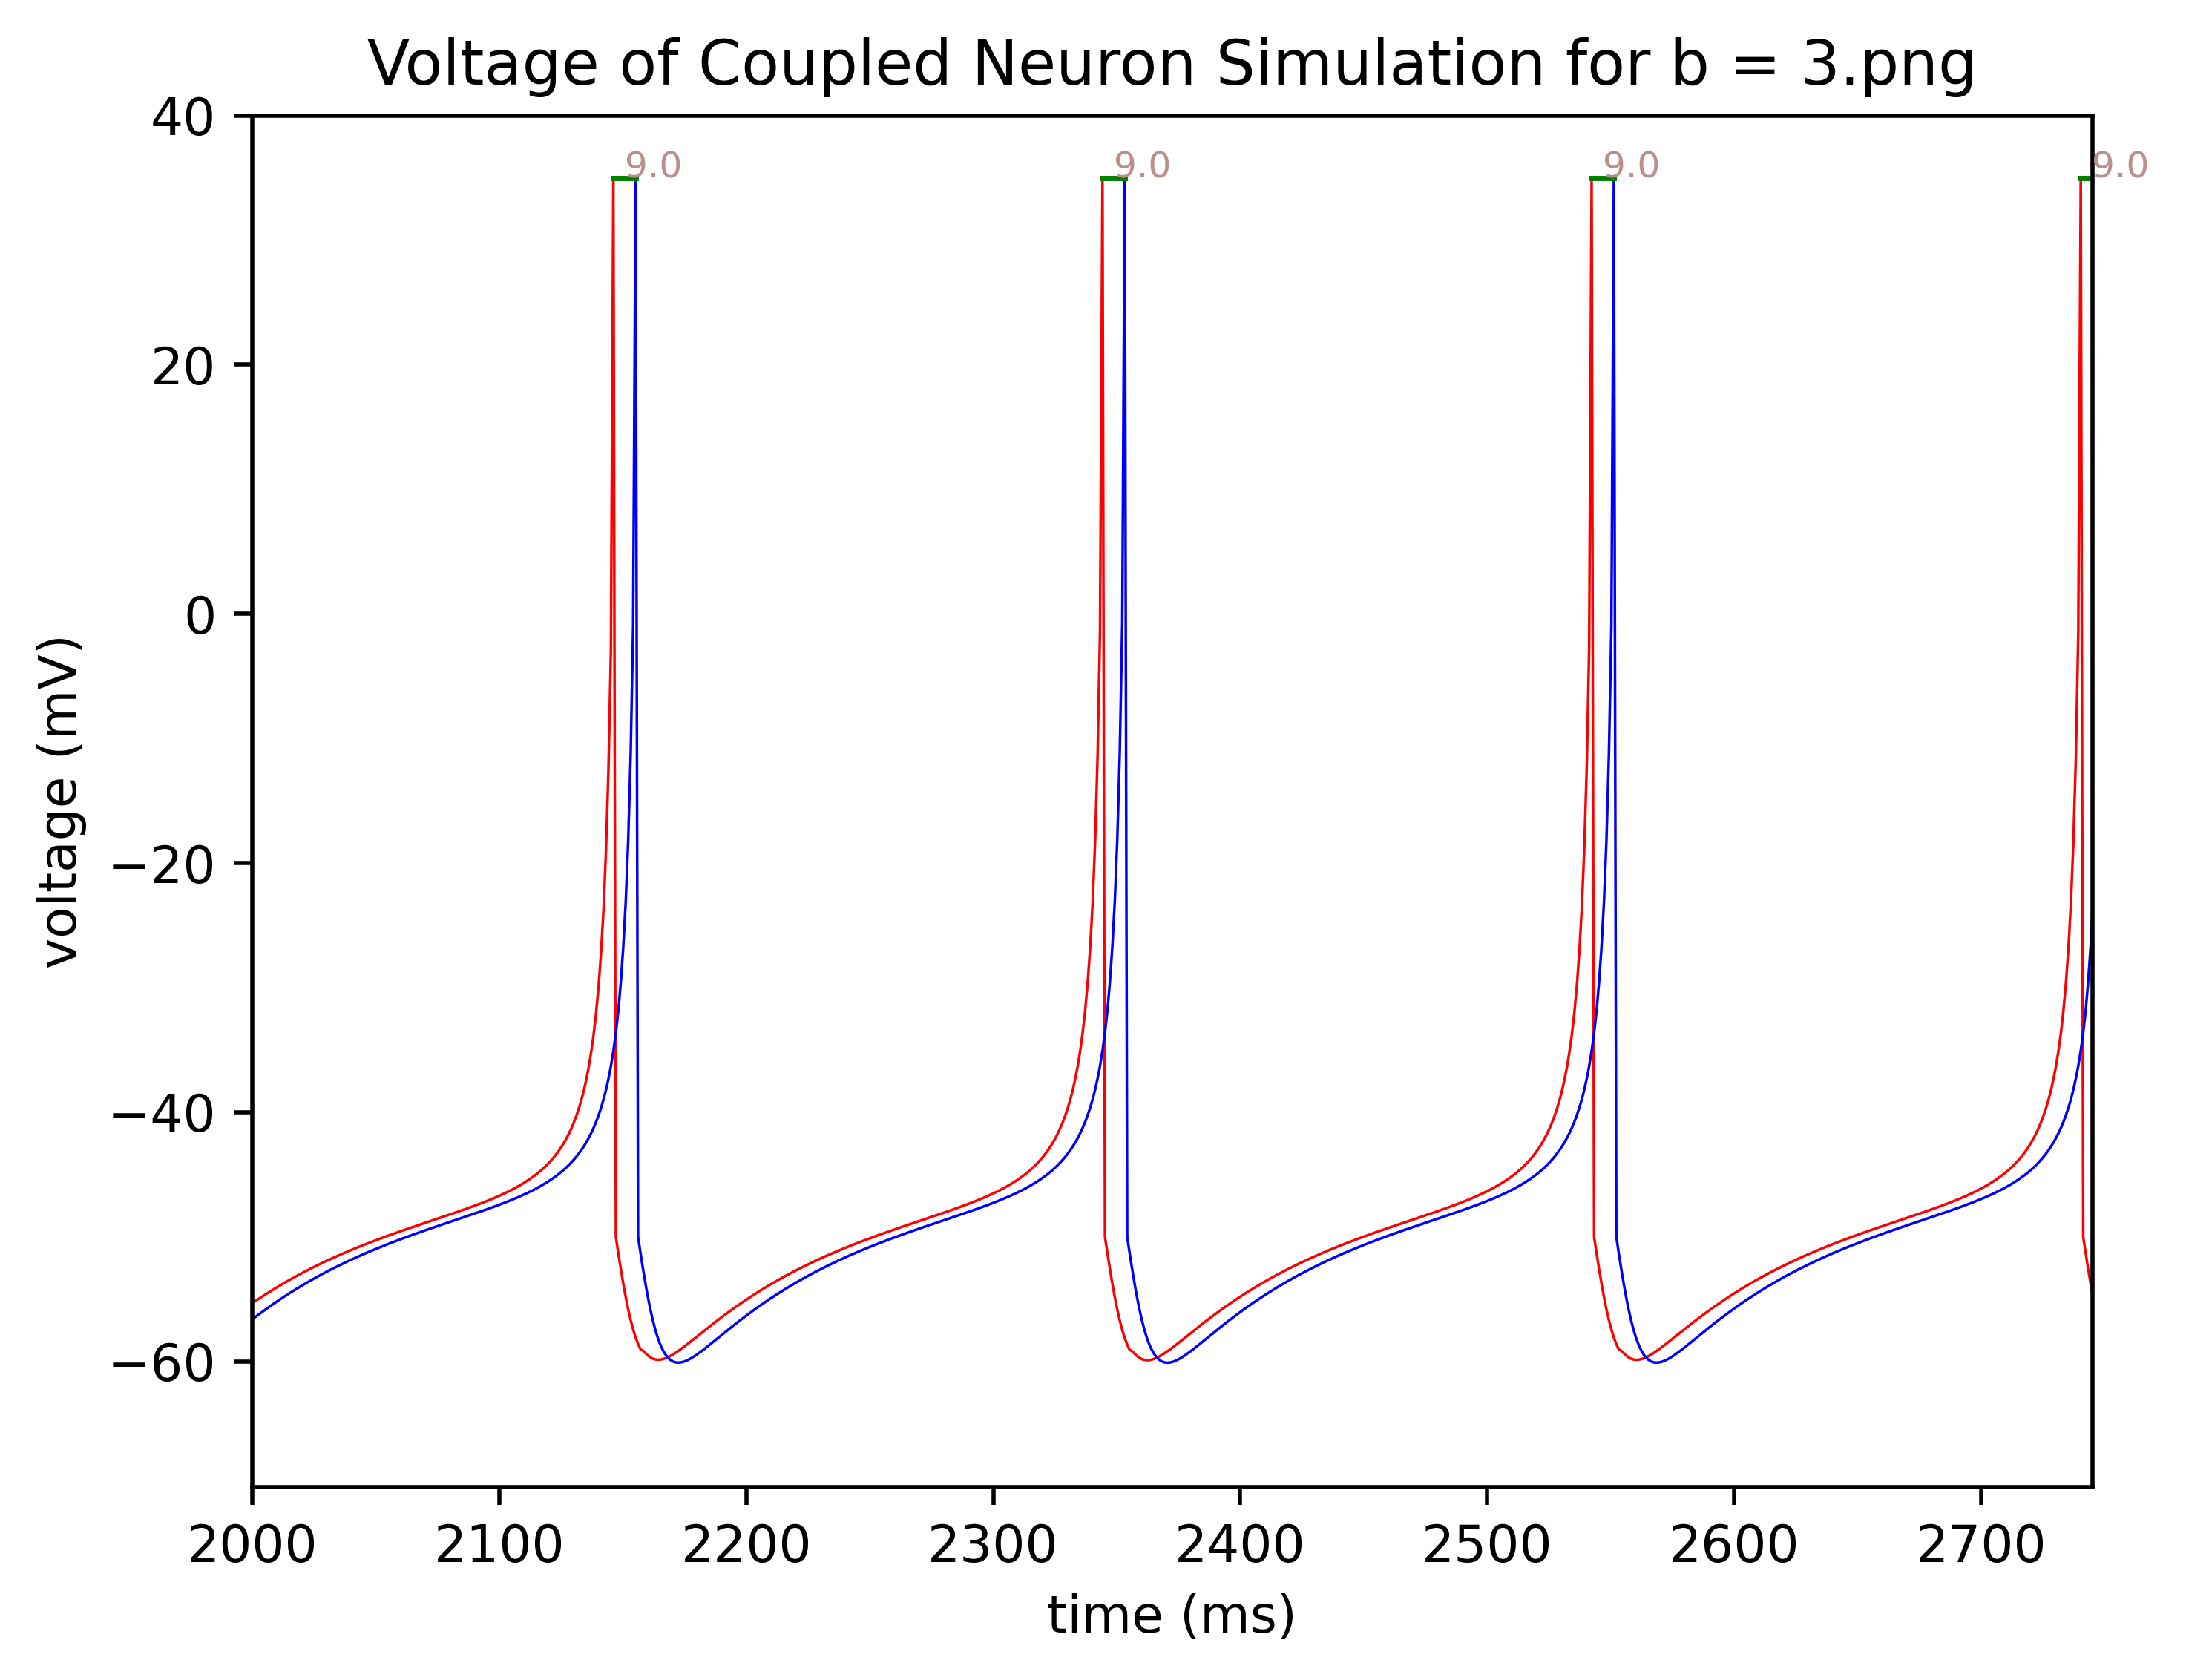

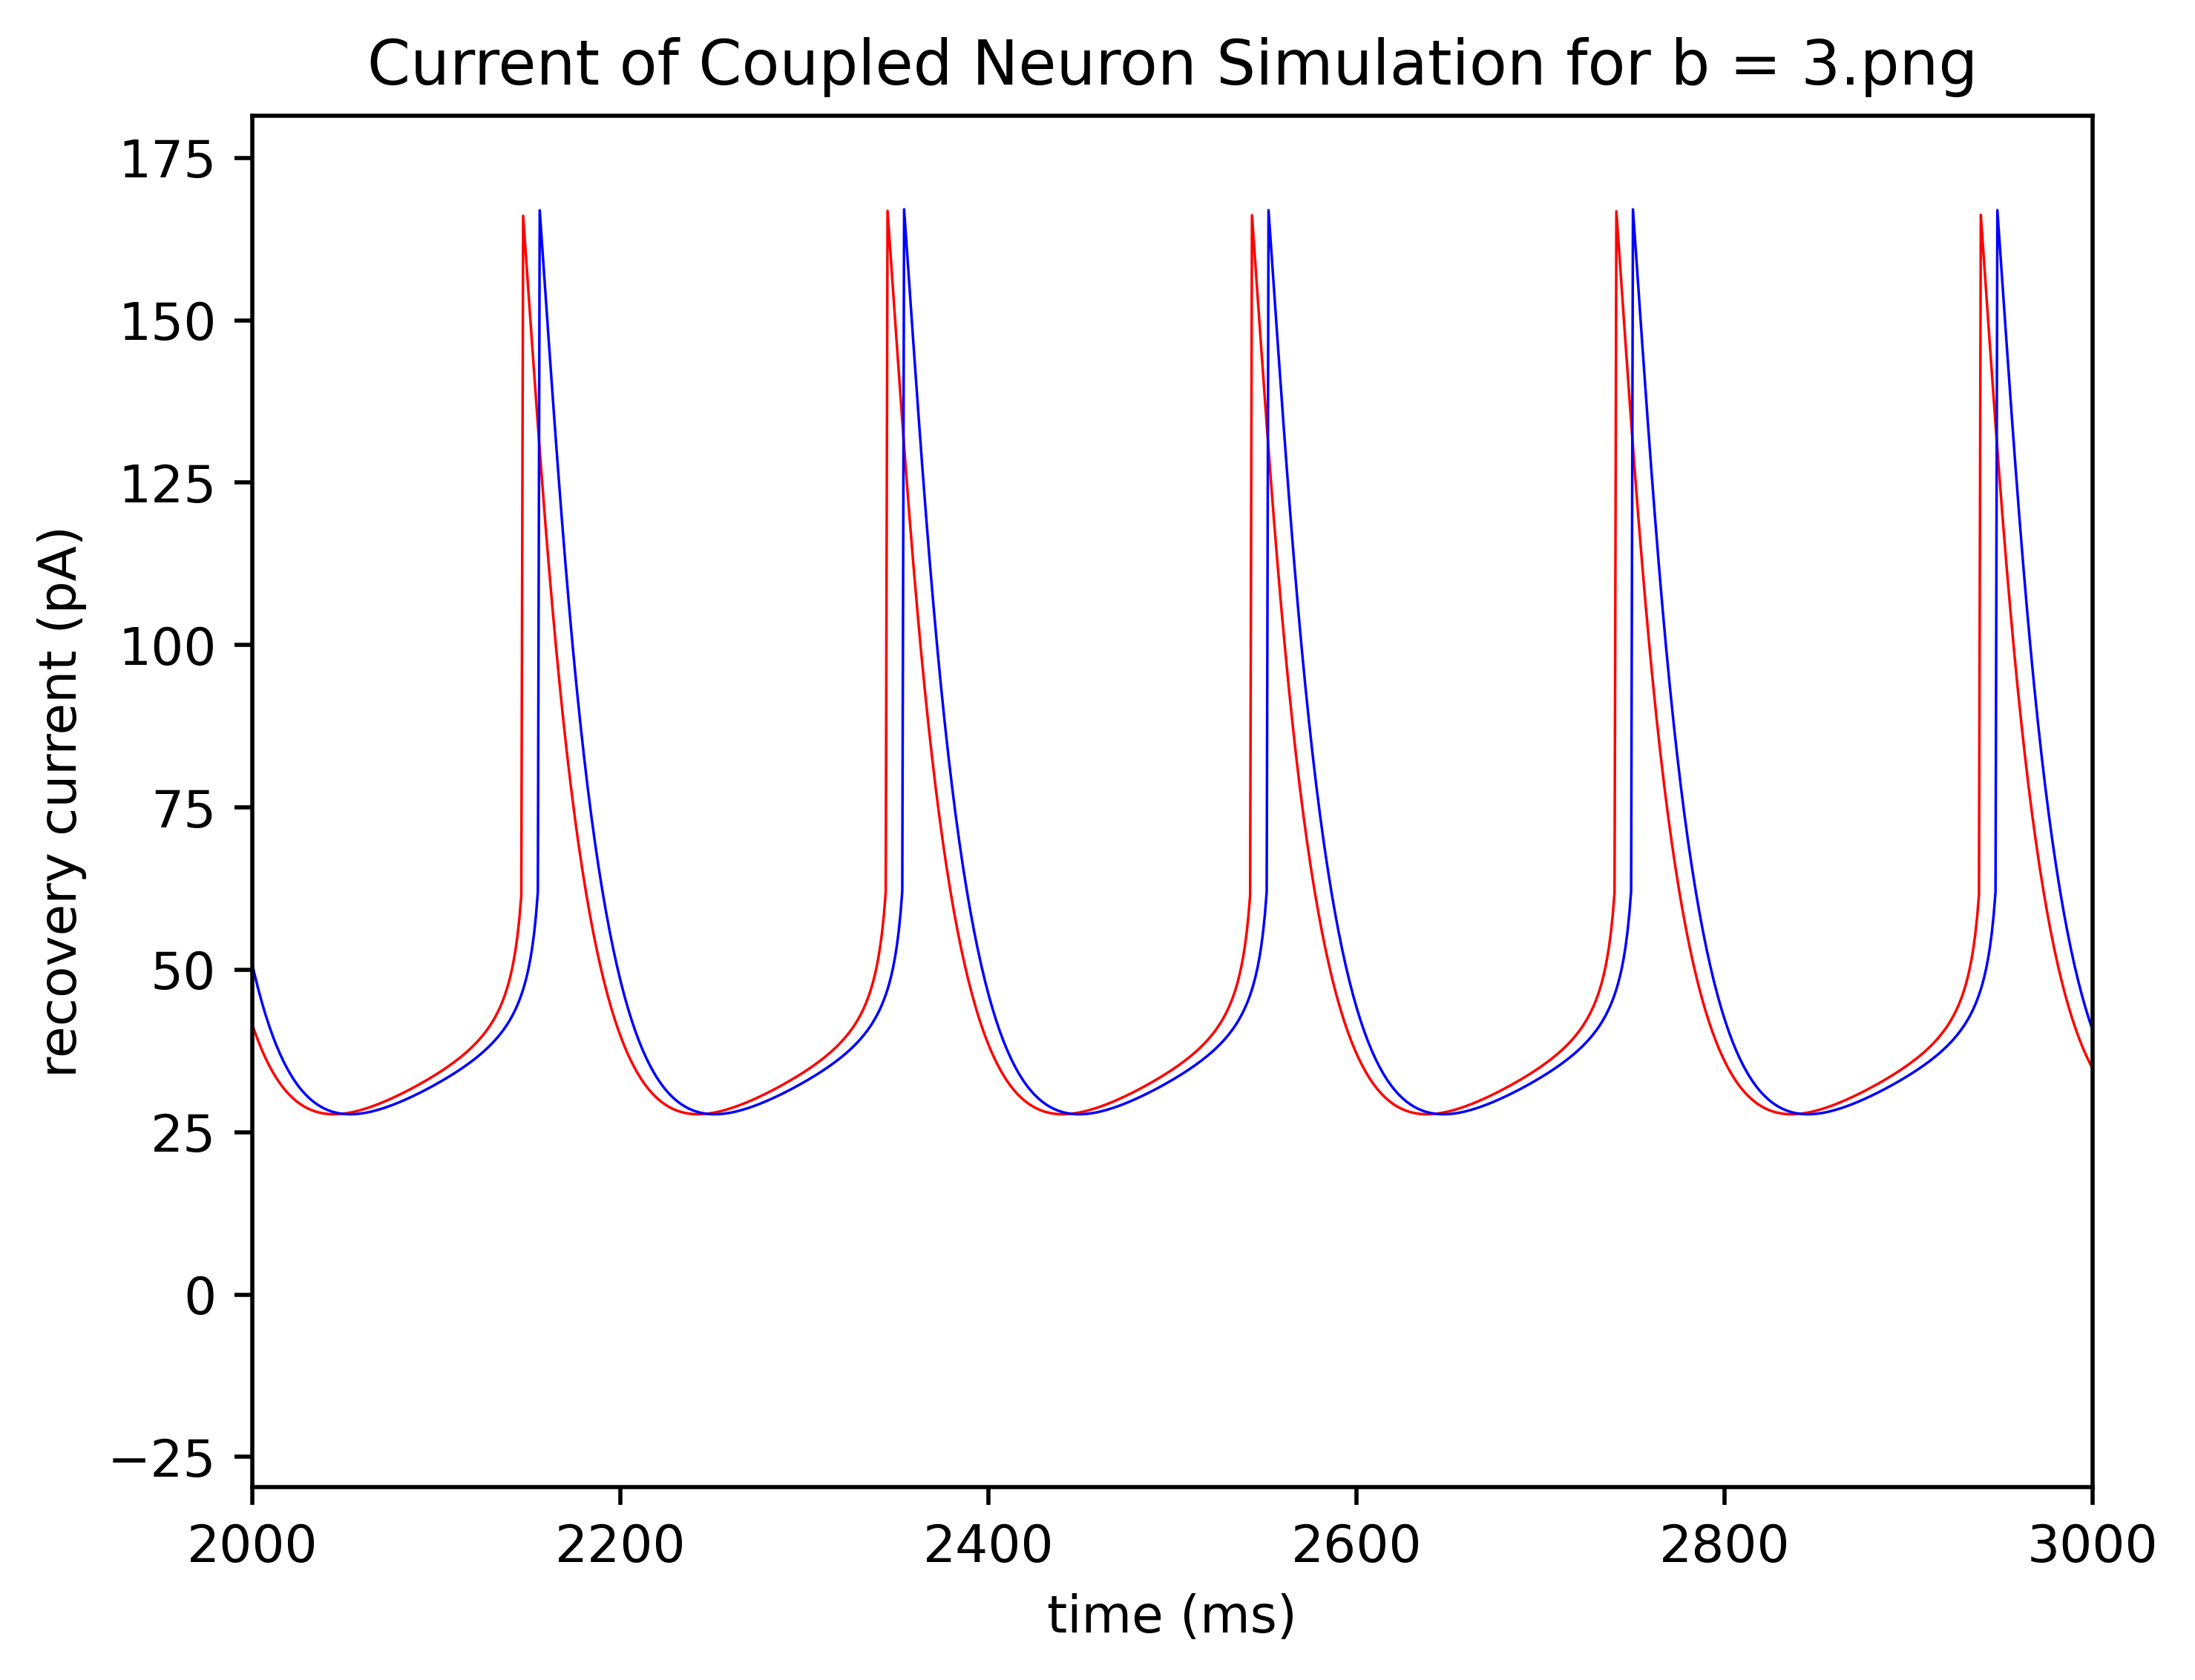

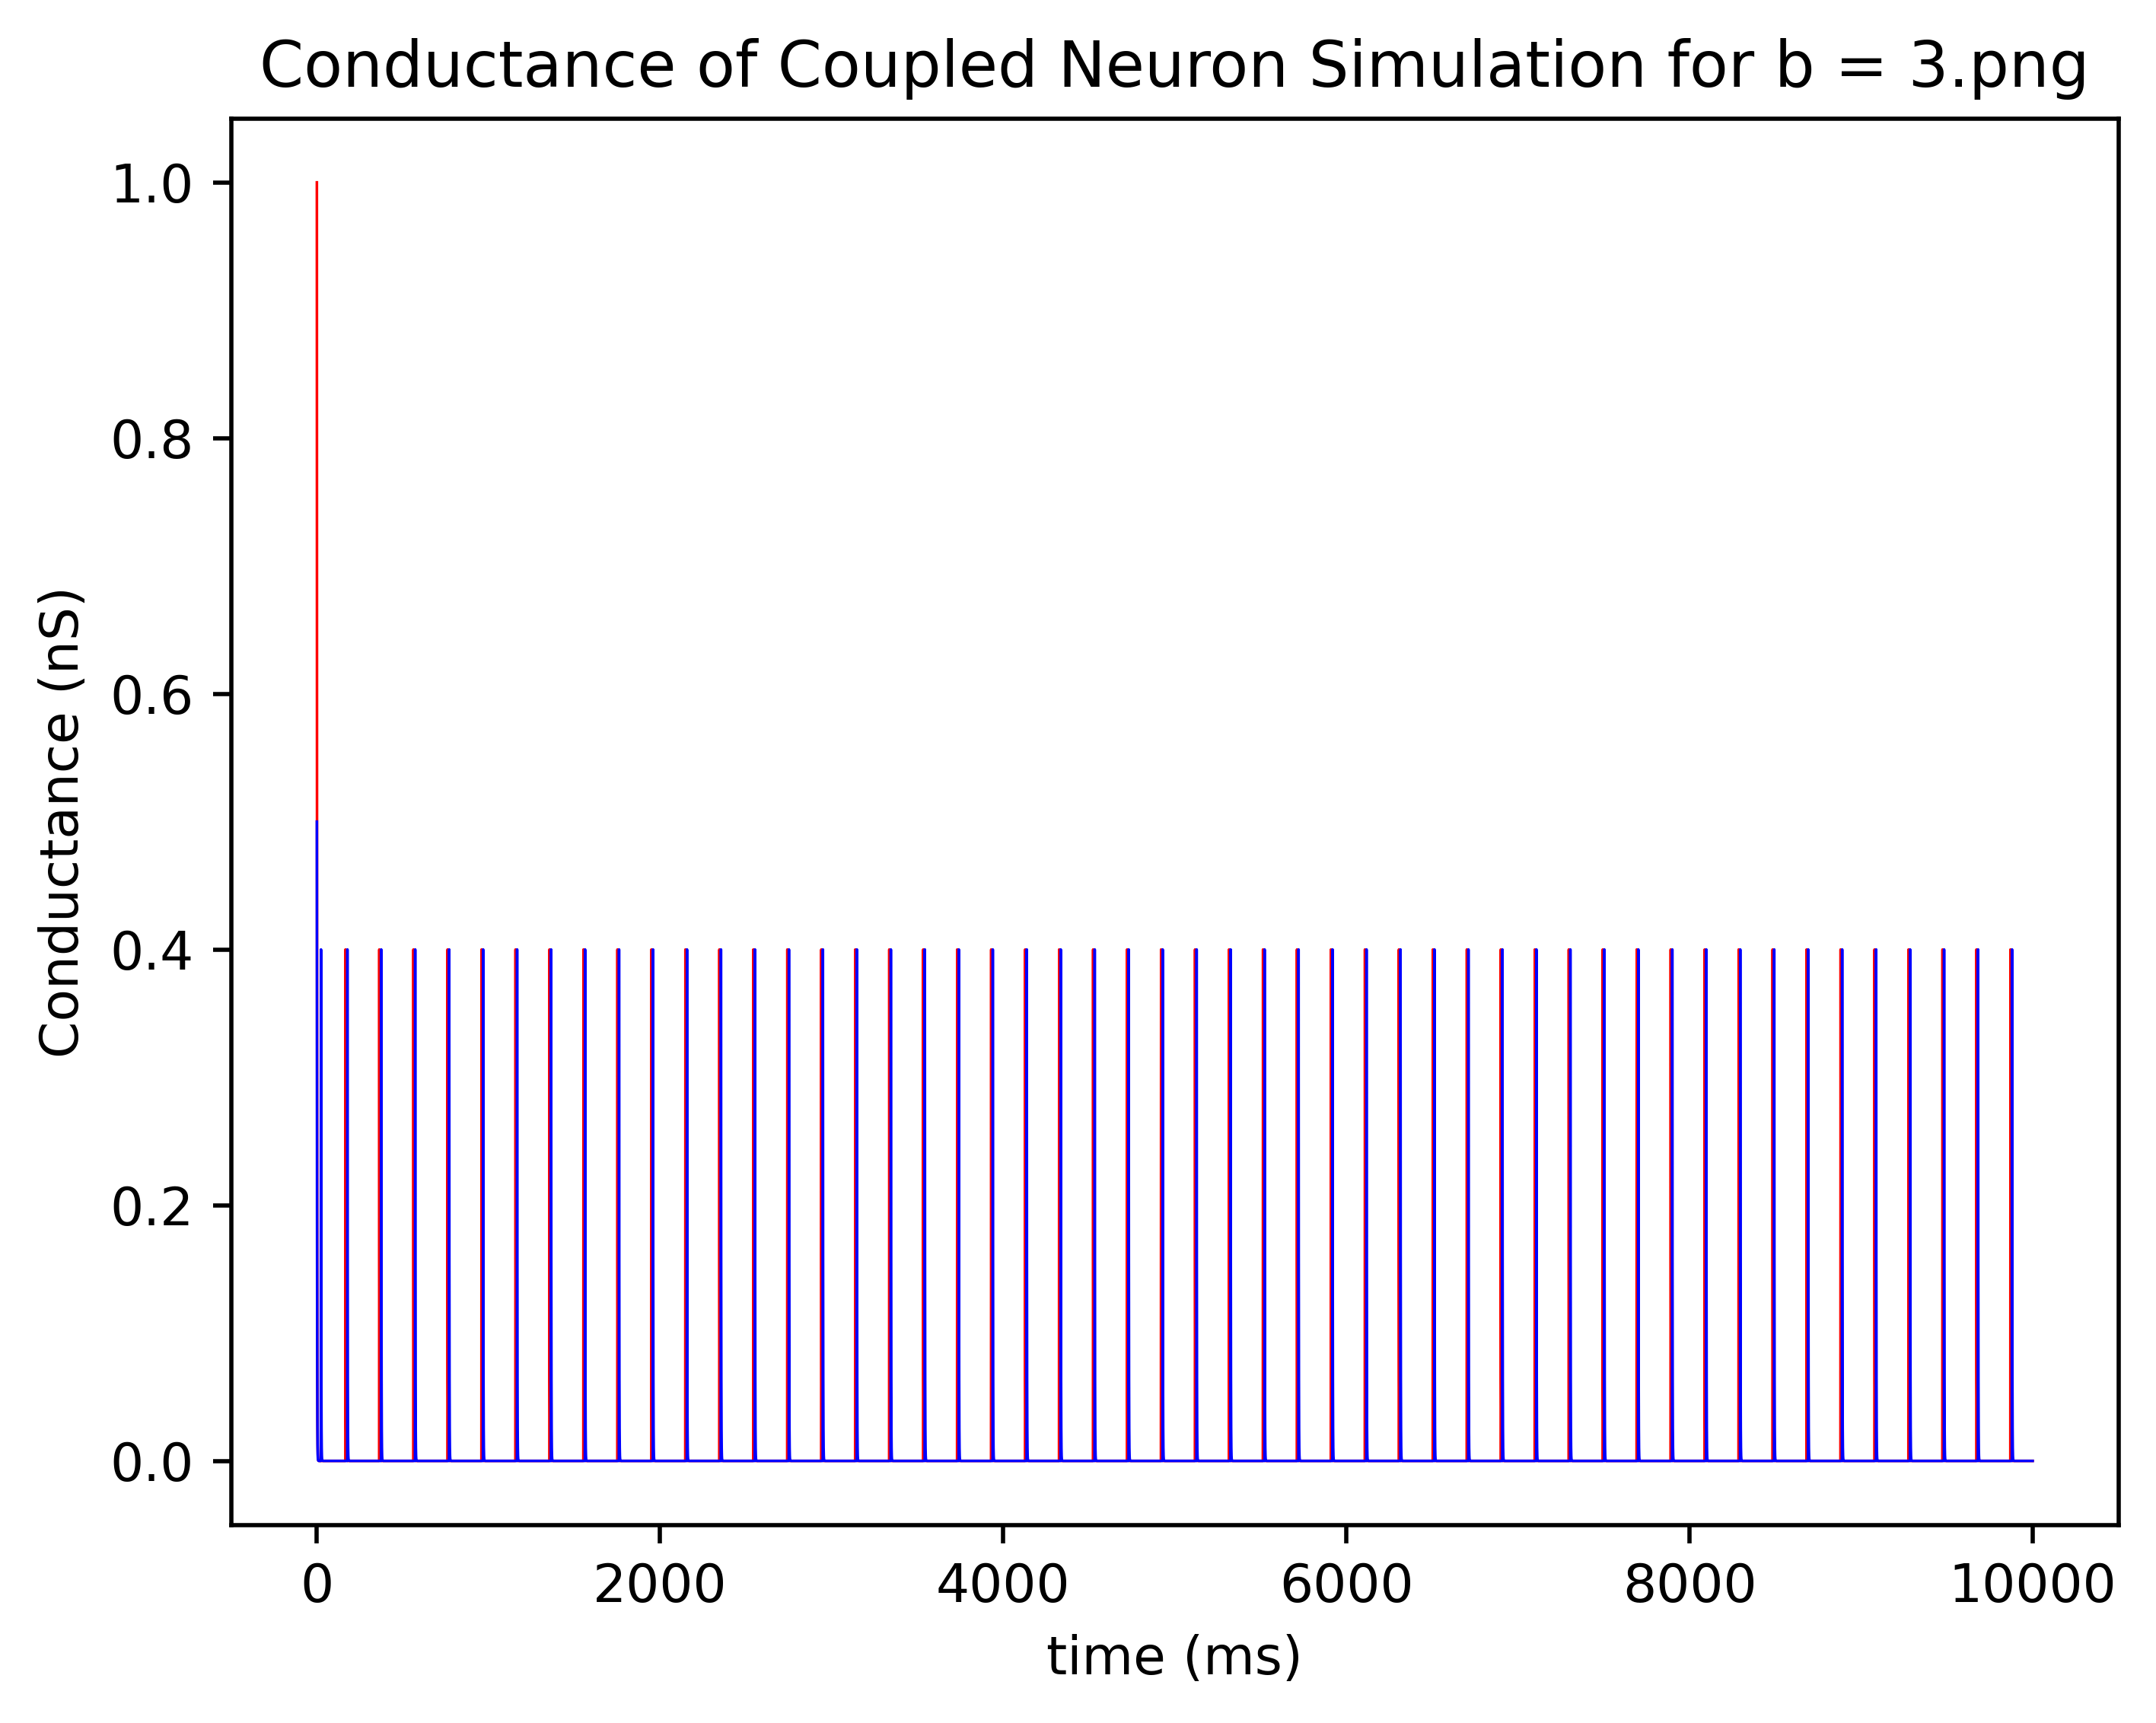

In [439]:
C = 100
k = 0.7
vr = -60
vt = -40
a = 0.03
b = 3
c = -50
d = 100
vpeak = 35
neuron_para_dict = {
    'C': C,
    'k': k,
    'vr': vr,
    'vt': vt,
    'a': a,
    'b': b,
    'c': c,
    'd': d,
    'vpeak': vpeak
}
multiplier = 1
T = 10000 * multiplier
h = 1
IC = np.array([[vr, vr+20],[0, -20],[1, 0.5]])
method = 'Euler'
conductance = 'open and closed channels'
H_inf_type = 'step'
v_zoom = [2000, 2745]
u_zoom = [2000, 3000]
s_zoom = None
fig1, fig2, fig3 = coupled_neuron_plot(neuron_para_dict, T, h, IC, method, conductance, H_inf_type, v_zoom, u_zoom, s_zoom)

In [253]:
plt.show()

In [363]:
type(np.arange(10)[0])

numpy.int64